In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from User_Classes import UserClass
from Advertising_Environment import calculate_margin, calculate_price_index
from Clairvoyant import find_optimal_bid_for_class
from Advertising.GPTS_Learner import GPTS_Learner

import warnings
warnings.filterwarnings("ignore")

# Environment

In [5]:
#Environment
n_arms = 100
min_bid = 0.01
max_bid = 3.0
bids = np.linspace(min_bid, max_bid, n_arms)
sigma = 200

user = UserClass(name='C1')

#names = ['Young ', 'Old', 'Not Sporty', 'Sporty']

price = 200
T = 365
n_experiments = 1000

gpts_rewards_per_experiment = []

optimum_bid = find_optimal_bid_for_class(user.user_index, calculate_price_index(price))

In [6]:
def fun(user_class, bid, price):
    mean_per_bid = user_class.get_click_bids(bid) * (user_class.get_conversion_per_price(price) * calculate_margin(price)) - user_class.get_click_bids(bid) * user_class.get_cost_per_click(bid)    #sample_cost
    return mean_per_bid

In [7]:
class BiddingEnvironment:
    def __init__(self, bids, sigma, user_class, price, n_arms):
        self.bids = bids
        self.means = self.initialize_means(user_class=user_class, bids=bids, price=price)
        self.sigmas = np.ones(len(bids)) * sigma
        self.price = price
        self.n_arms = n_arms

    def initialize_means(self, user_class, bids, price):
        means = np.zeros(len(bids))
        for i in range(len(means)):
                means[i] = fun(user_class, bids[i], price)
        return means

    def round(self, pulled_arm):
        #print('Means')
        #print(self.means[pulled_arm])
        #print('Means Array')
        #print(self.means)
        return np.random.normal(self.means[pulled_arm], self.sigmas[pulled_arm])

# Experiment

In [9]:
for e in tqdm(range(0, 2)):
    env = BiddingEnvironment(bids=bids, sigma = sigma, user_class=user, price=price, n_arms=n_arms)
    gpts_learner = GPTS_Learner(n_arms, arms=bids)

    for t in tqdm(range(T)):
        #GP Thompson Sampling
        pulled_arm = gpts_learner.pull_arm()
        reward = env.round(pulled_arm)
        gpts_learner.update(pulled_arm, reward)

    gpts_rewards_per_experiment.append(gpts_learner.collected_rewards)

100%|██████████| 2/2 [03:12<00:00, 96.25s/it]


In [10]:
gpts_rewards_per_experiment[1]

array([12915.58446422, 13490.40681814, 13575.18258132, 13682.54234011,
       13790.04484032, 13126.86038182, 13920.02904425, 13787.3488667 ,
       14111.72630131, 13779.8579389 , 13875.40318425, 13462.89508332,
       12519.50705338, 13739.98060529, 14015.51972521, 13964.27100918,
       14134.85060405, 13943.28069327, 13566.98545343, 14032.5494964 ,
       13988.91783892, 13891.41516038, 12422.1081192 , 13895.05009323,
        9981.54293342, 13526.98266608, 13882.85575426, 14185.0482733 ,
       13916.32834106, 14021.15425585,  9898.23713032, 13662.00978334,
       13777.35610952, 13574.95210157, 13888.21062205, 13899.58608354,
        6822.48748858, 13101.04999957, 13843.56751869, 13770.80394425,
       12171.66813629, 13933.76204402, 13868.19562327, 13793.20685125,
       13572.7839162 , 13781.63461484, 12776.66908717, 13668.08780573,
       13890.13927619, 13735.81574923, 13828.22269324, 14122.09856502,
       13892.67698554, 13588.8322847 , 13447.24381534, 13600.02663785,
      

In [11]:
optimum_bid

(1.0, 13767.97338369385)

# Plot Regret

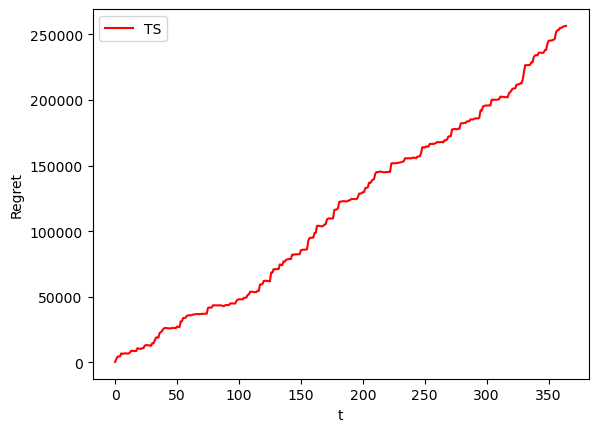

In [12]:
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(optimum_bid[1] - gpts_rewards_per_experiment, axis=0)), 'r')
plt.legend(["TS", "UCB"])
plt.show()

# Plot Reward

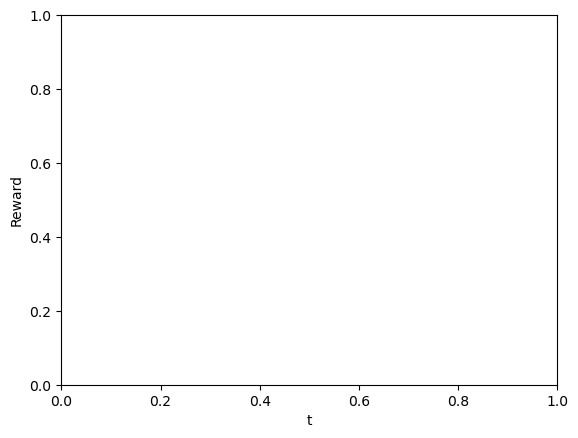

In [22]:
plt.figure(1)
plt.ylabel("Reward")
plt.xlabel("t")
leg = "GPTS Learner"
maxes = []
opt_line = np.ones(shape=1) * optimum_bid[1]

In [24]:
len(gpts_rewards_per_experiment)

2

[array([13758.25625087,  9648.60494763, 10252.93133468, 13587.19492851,
       13632.10118645,  9964.17132987, 14025.72365956, 13781.45493189,
       12783.18894096, 13909.95390035, 13876.04995953, 13788.08972293,
       13856.55461727, 10969.23112814, 13726.64658408, 13629.07793172,
       13562.14724573, 13777.38843525,  9647.56972427, 13893.9308064 ,
       13797.88121078, 13913.79672151, 13881.65032706, 13568.54049424,
       13746.04831342, 13299.08719862, 13740.57741505, 13585.24984186,
       14057.44746821, 13711.90308161, 13963.24248911, 13920.29267248,
        9636.92003855,  9397.30843499, 13408.26239701, 13775.46461735,
       13601.93212327, 13328.25478473, 11454.1654571 , 11084.95959077,
       13893.36356444, 13690.02638713, 13964.37891519, 13894.2075358 ,
       13975.34801761, 13856.10656388, 13991.26072713, 13971.71278609,
       13719.52009575, 13882.09954708, 11404.14959336, 13881.75828025,
       14109.09543762,  5089.5209955 , 13799.69703216,  8994.83076419,
     

TypeError: object of type 'int' has no len()

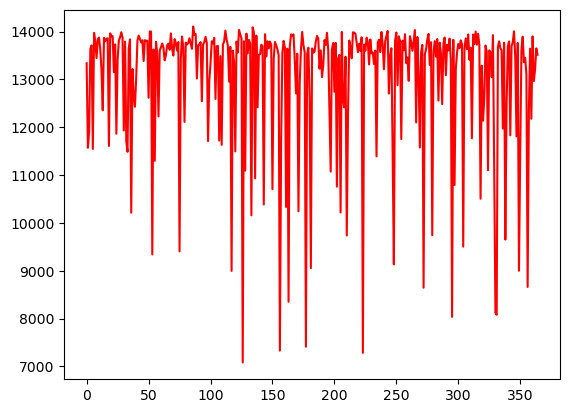

In [23]:
plt.plot(opt_line, 'k')
for line in [gpts_rewards_per_experiment]:
    curve = np.nanmean(line, axis=0)
    maxes.append(np.max(curve))
    print(line)
    plt.plot(curve, "r")
    for i in range(len(gpts_rewards_per_experiment)):
        plt.plot(line[i], "g", alpha=1 / np.power(len(gpts_rewards_per_experiment), 2/3))
#plt.ylim([15000, 1.2 * np.max(maxes, axis=0)])
#plt.legend(leg)
plt.show()